# Summary

This project centered on constructing a robust classifier for Iris species classification using the well-known Iris dataset initially introduced by Ronald A. Fisher. The project spanned various key phases, each playing a pivotal role in enhancing our understanding of the dataset and building an accurate model.

the dataset used for this project was sourced from [Kaggle](https://www.kaggle.com/datasets/uciml/iris/data) and found to be relatively clean, requiring only minimal preprocessing. Notably, labels were simplified by removing the "Iris-" prefix, and outliers were retained due to the dataset's limited size, containing just 150 entries.

The [dimensionality Reduction](#dimensionality-reduction) section explored using various dimensionality reduction techniques, including PCA, t-SNE, and UMAP. While these techniques fell short of creating separate clusters for all three classes, a more focused approach targeting "versicolor" and "virginica" emerged, using feature elimination to zoom in on petal attributes.

The [Model Development and Evaluation](#model-development-and-evaluation) phase involved a two-step model. PCA was employed for dimensionality reduction, followed by SVM for preliminary classification. For cases requiring differentiation between "versicolor" and "virginica," feature elimination was applied to focus on petal length and width, with a Logistic Regression model making the final distinction.

Model performance was rigorously evaluated through 100 tests involving randomized training and testing data. The results demonstrated robust accuracy, averaging 0.96±0.03 in testing data, reinforcing the model's effectiveness in Iris species classification.

In conclusion, This project was successful in building a dependable Iris species classifier. The model's adaptability, combining dimensionality reduction and feature elimination, has proven to be a potent strategy. Beyond this project, the insights gained extend to complex classification problems, offering valuable lessons and reinforcing their applicability in future data science and research endeavors.

# Table of Contents

0. [Summary](#summary)
1. [Introduction](#introduction)
2. [Data Exploration](#data-exploration)
    - [Checking for outliers](#checking-for-outliers)
    - [Dimensionality Reduction](#dimensionality-reduction)
    - [Versicolor vs. Virginica](#versicolor-vs-virginica)
    - [Data Exploration Conclusions](#data-exploration-conclusions)
3. [Model Development and Evaluation](#model-development-and-evaluation)
4. [Conclusions](#conclusions)


# Introduction

The Iris dataset, originally introduced by the renowned British biologist and statistician Ronald A. Fisher in 1936, has long served as a fundamental benchmark in the fields of classification and clustering. This dataset, consisting of measurements of Iris flowers' sepal length, sepal width, petal length, and petal width, has become a classic toy problem for data analysis and machine learning. This project's goal is to build an accurate classifier capable of identifying an Iris flower's species with a minimum accuracy threshold of 95%.

To achieve our overarching goal of accurate Iris species classification, we have established the following key objectives:

1. **Data Collection and Cleaning**: 
	- Collect the Iris dataset from a reputable source, ensuring data integrity and completeness.
	- Conduct meticulous data cleaning and preprocessing, addressing any missing values or anomalies that may affect the quality of the data.
2. **Preliminary Data Exploration:**
	- Conduct an initial exploration of the Iris dataset to gain insights into its structure and characteristics.
	- Generate summary statistics and visualizations to identify potential issues, patterns, or outliers in the data..
3. **Data Preprocessing**:
	- Handle outlier detection and treatment to ensure the dataset is suitable for modeling.
	- Encode categorical variables and handle any other data-specific preprocessing tasks.
4. **Feature Engineering**:
	- Identify and select the most relevant features for classification.
	- Implement feature scaling, normalization, or dimensionality reduction techniques to enhance the model's performance.
5. **Model Development and Evaluation**:
	- Explore and experiment with various classification models, possibly including ensemble methods, to determine the most suitable approach.
	- Employ rigorous evaluation techniques, including data splitting for training and testing, to assess and fine-tune model performance.
	- Evaluate the models using a range of metrics, including accuracy, precision, recall, F1-score, and confusion matrix, to provide a comprehensive understanding of classification performance.

# Data Exploration

In [1]:
import pandas as pd

df = pd.read_csv('./data/Iris.csv')

print(f'columns: {df.columns.tolist()}')

df['Species'] = df['Species'].apply(lambda x: x.split('-')[-1]) # removing the `Iris-` prefix from the labels
classes = df["Species"].unique().tolist()
print(f'classes: {classes}')
for species in classes:
    n = len(df[df['Species'] == species])
    print(f'\t- {species}: {n} entries')

print('Missing values:')
print(df.isna().any())
print(df.head())

columns: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
classes: ['setosa', 'versicolor', 'virginica']
	- setosa: 50 entries
	- versicolor: 50 entries
	- virginica: 50 entries
Missing values:
Id               False
SepalLengthCm    False
SepalWidthCm     False
PetalLengthCm    False
PetalWidthCm     False
Species          False
dtype: bool
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm Species
0   1            5.1           3.5            1.4           0.2  setosa
1   2            4.9           3.0            1.4           0.2  setosa
2   3            4.7           3.2            1.3           0.2  setosa
3   4            4.6           3.1            1.5           0.2  setosa
4   5            5.0           3.6            1.4           0.2  setosa


Just from loading the data in, we see the following characteristics:
- There are 150 entries in the dataset
- **The dataset has 4 features:** Sepal length (cm), Sepal width (cm), Petal length (cm), and Petal width (cm)
- **There are 3 unique classes:** Setosa, Versicolor, and Virginica
- there are no missing values in the dataset

## Checking for outliers

- we must check for outliers in the different classes separately

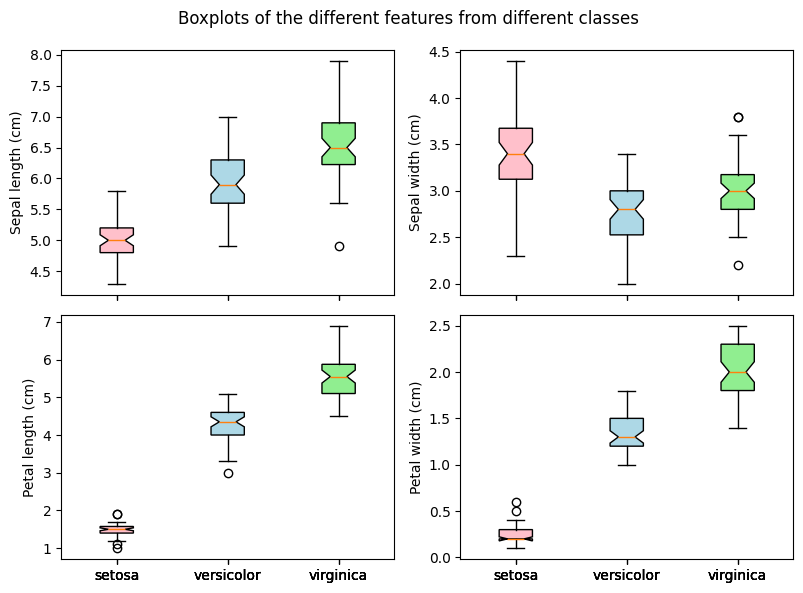

In [2]:
from itertools import product
import matplotlib.pyplot as plt
feature_columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
column_labels = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
colors = ['pink', 'lightblue', 'lightgreen']

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8, 6))
fig.suptitle('Boxplots of the different features from different classes')
for (i, j), feature, label in zip(product(range(2), range(2)), feature_columns, column_labels):
    data = [df[df['Species'] == species][feature].to_numpy() for species in classes]
    bplot = ax[i, j].boxplot(data, labels=classes, notch=True, patch_artist=True)
    ax[i, j].set_ylabel(f'{label} (cm)')
    for patch, color in zip(bplot['boxes'], colors):
        patch.set(facecolor=color)
fig.tight_layout()

Just using a boxplot, we can immediately see that there are some outliers outside the inter-quartile range (IQR). However, since the dataset is small (only 50 entries per class), the outliers might be explained by the variance in the dataset. Furthermore, while there are outliers, they seem concentrated enough to not interfere with the classification task. Thus, we decide not to eliminate any datapoints.

## Dimensionality Reduction

As a preprocessing step, we can test if the following dimensionality reduction techniques would help the classification task:
- Principal component analysis (PCA)
- t-Distributed Stochastic Neighbor Embedding (t-SNE)

### Principal Component Analysis

First, we need to figure out how much we can reduce the dimensions. This can be done by checking the cumulative explained variance each time we add an additional principal component.

principal components: 1, explained variance: 0.92
principal components: 2, explained variance: 0.98
principal components: 3, explained variance: 0.99
principal components: 4, explained variance: 1.00


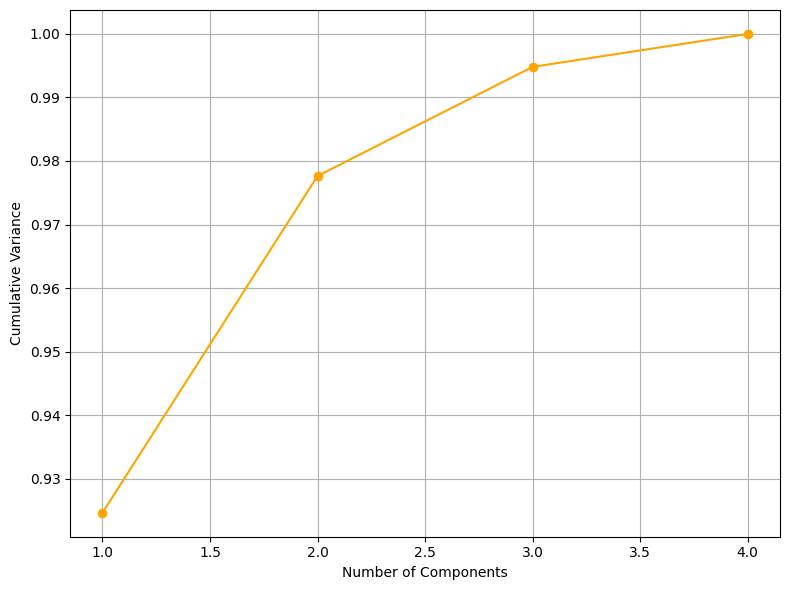

In [3]:
from sklearn.decomposition import PCA
import numpy as np

def pca(data, num_components=2):
    # Initialize PCA
    pca_obj = PCA(n_components=num_components)

    # Fit PCA to the standardized data
    pca_obj.fit(data)

    # Transform the data to the first 'num_components' principal components
    data_pca = pca_obj.transform(data)

    # Create a DataFrame to visualize the transformed data
    df_pca = pd.DataFrame(
        data_pca, columns=[f"PC{i + 1}" for i in range(num_components)]
    )

    # Print the explained variance ratio for each principal component
    explained_variance_ratios = pca_obj.explained_variance_ratio_

    return df_pca, explained_variance_ratios

pca_data, explained_variance = pca(df[feature_columns], 4)
cumulative_explained_variance = np.cumsum(explained_variance)
num_of_features = len(feature_columns)
for i, exp_var in zip(range(1, num_of_features+1), cumulative_explained_variance):
    print(f'principal components: {i}, explained variance: {exp_var:.2f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_of_features+1), cumulative_explained_variance, 'o-', color='orange')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.tight_layout()


It is evident that there is a relative improvment from between using one pricipal component and two principal components. For this analysis, we will use 2 principal components simply because there is not much drawbacks in doing so and it would make it easier to visualize the data in a scatterplot.

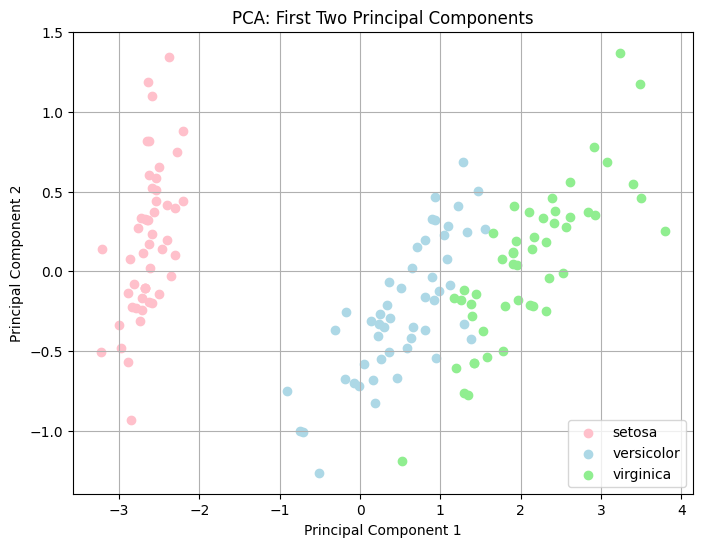

In [4]:
plt.figure(figsize=(8, 6))
for species, color in zip(classes, colors):
    print()
    plt.scatter(pca_data['PC1'][df['Species'] == species], pca_data['PC2'][df['Species'] == species], c=color, label=species)
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

From the PCA, we see that there are three distinct clusters. However, it is also evident that the versicolor cluster is a bit too close to the virginica cluster which may impede in the classification process.

### t-distributed Stochastic Neighbor Embedding

t-SNE is different from PCA in such a way that it is a non-linear dimensionality reduction technique. Thus, we check if it would give better results than PCA in separating the versicolor and virginica clusters.

*_Just like what we did in PCA, we reduce the dimensionality of the data into 2 dimensions_

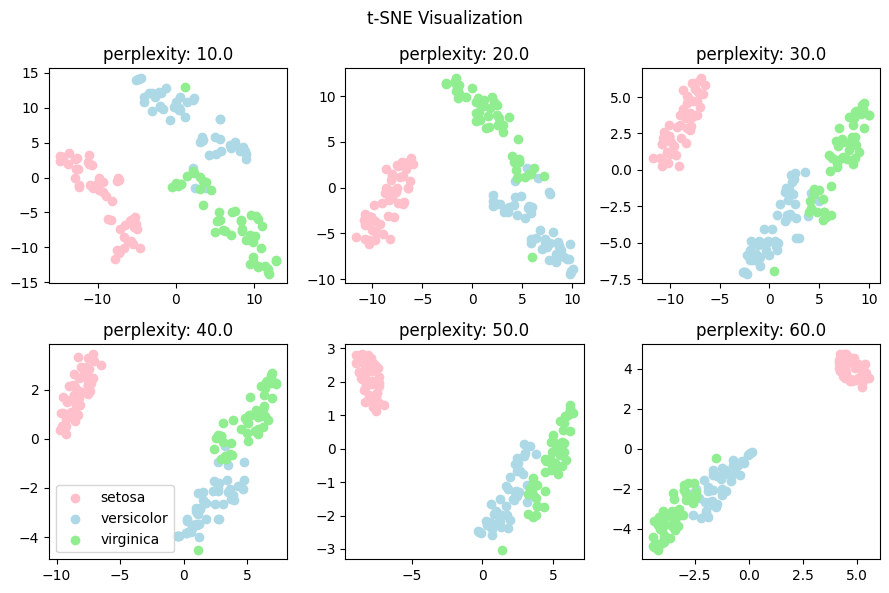

In [5]:
from sklearn.manifold import TSNE

def tsne(data, n_components=2, perplexity=30.0, n_iter=300, random_state=0):
    tsne_model = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    tsne_result = tsne_model.fit_transform(data)
    return tsne_result

perplexities = [10., 20., 30., 40., 50., 60.]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for (i, j), perplexity in zip(product(range(2), range(3)), perplexities):
    tsne_result = tsne(df[feature_columns], perplexity=perplexity)
    for species, color in zip(classes, colors):
        ax[i, j].scatter(tsne_result[:, 0][df['Species'] == species], tsne_result[:, 1][df['Species'] == species], c=color, label=species)
        ax[i, j].set_title(f'perplexity: {perplexity}')


fig.suptitle("t-SNE Visualization")
ax[1, 0].legend()
fig.tight_layout()

visually checking, it seems like the output of t-SNE with perplexity values 20 or 30 are better compared to using PCA for a classification task.

### Uniform Manifold Approximation

finally, we can also try using Uniform Manifold Approximation (UMAP) if it would provide better results.

c:\Users\Richard\Documents\Dev\venvs\iris-classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


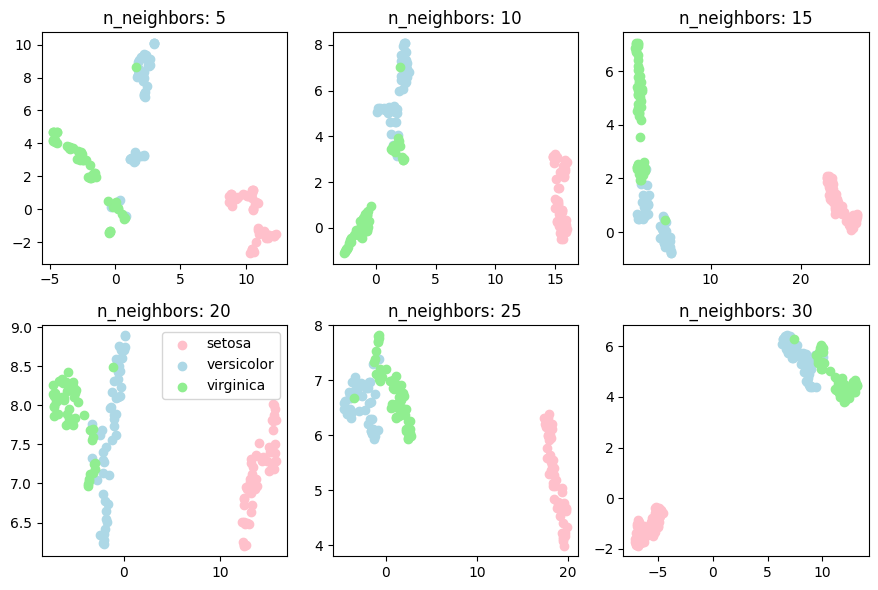

In [6]:
import umap

n_neighbors = [5, 10, 15, 20, 25, 30]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for (i, j), n in zip(product(range(2), range(3)), n_neighbors):
    umap_model = umap.UMAP(n_components=2, n_neighbors=n, min_dist=0.05)
    umap_result = umap_model.fit_transform(df[feature_columns])
    tsne_result = tsne(df[feature_columns], perplexity=perplexity)
    for species, color in zip(classes, colors):
        ax[i, j].scatter(umap_result[:, 0][df['Species'] == species], umap_result[:, 1][df['Species'] == species], c=color, label=species)
        ax[i, j].set_title(f'n_neighbors: {n}')

ax[1, 0].legend()
fig.tight_layout()

Unfortunately, it dosen't seem like UMAP improved the dimensionality reduction much. Additionally, UMAP takes a while to fit to the data so we're probably better off just using t-SNE.

## Versicolor vs. Virginica

While the dimensionality reduction techniques that we have tested worked at preserving the clusters of datapoints that are in the same class, it had trouble differentiating between versicolor and virginica. Thus, we can isolate the problem and explore ways of differentiating between versicolor and virginica.

### t-Test between the features

One method that explore is using a t-test to check each feature and see if there are features of Versicolor that is significantly different from Virginica.

In [7]:
from scipy.stats import ttest_ind

versicolor = df[df['Species'] == 'versicolor']
virginica = df[df['Species'] == 'virginica']

alpha = 0.05
for feature in feature_columns:
    t_stat, p_val = ttest_ind(versicolor[feature], virginica[feature], alternative='two-sided')
    print(f'feature: {feature}, t-stat: {t_stat:.4f}, p-val: {p_val:.4f}, is significant?: {p_val <= alpha}')

feature: SepalLengthCm, t-stat: -5.6292, p-val: 0.0000, is significant?: True
feature: SepalWidthCm, t-stat: -3.2058, p-val: 0.0018, is significant?: True
feature: PetalLengthCm, t-stat: -12.6038, p-val: 0.0000, is significant?: True
feature: PetalWidthCm, t-stat: -14.6254, p-val: 0.0000, is significant?: True


Unfortunately, the t-tests reveal that all the features are significant. However, notice that the t-statstics for the petal length and width are pretty high compared to the the sepal length and width.

### Feature Elimination

From the results in the previous section, it is evident that the t-statistics for the petal length and width are much higher than the sepal length and width. Thus, another avenue that we can explore is eliminating the sepal length and width from the features and classify Versicolor and Virginica using only the petal length and width.

Since eliminating `SepalLengthCm` and `SepalWidthCm` would leave us with two features, we can directly use a scatterplot to visualize the clustering of the data.

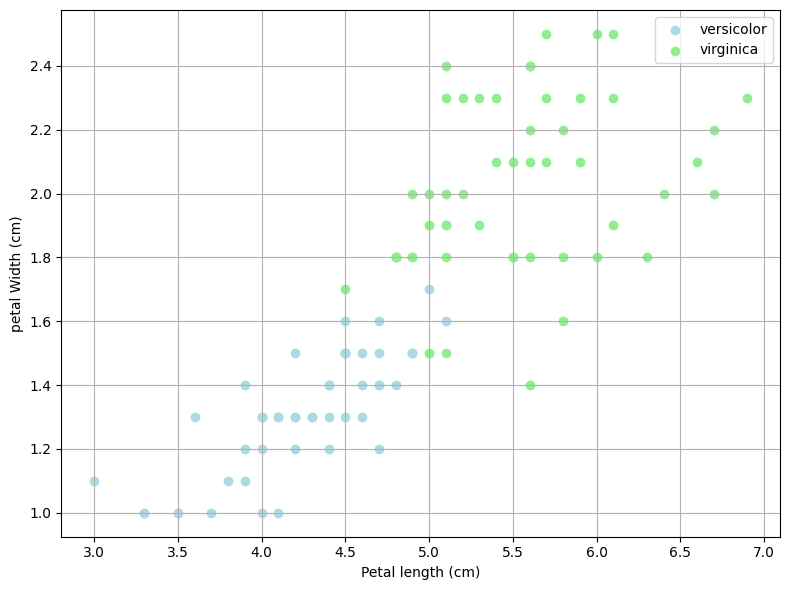

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(versicolor['PetalLengthCm'], versicolor['PetalWidthCm'], c='lightblue', label='versicolor')
plt.scatter(virginica['PetalLengthCm'], virginica['PetalWidthCm'], c='lightgreen', label='virginica')
plt.xlabel("Petal length (cm)")
plt.ylabel("petal Width (cm)")
plt.grid(True)
plt.legend()
plt.tight_layout()

The separation between the clusters are still not absolutely defined. However, this might be good enough and we can just test our model if we could achieve our target accuracy using this method.

## Data Exploration Conclusions

The Iris dataset contains 150 entries. The dataset did not have any missing values and no data cleaning was required. Furtermore, there are four features describes a single datapoint, namely, `SepalLengthCm`, `SepalWidthCm`, `PetalLengthCm`, and `PetalWidthCm`. Additionally, there are three distinct classes: `Iris-setosa`, `Iris-versicolor`, and `Iris-virginica`. The classes were later renamed into only `setosa`, `versicolor`, and `virginica` -- removing the `Iris-` prefix. While it was identified that there were some outliers in the dataset, removing them was deemed risking since the dataset was small with only 150 entries (50 entries per class).

[Dimensionality reduction](#dimensionality-reduction) techniques were also applied to the features of the dataset and it was found that it is possible to reduce the dimensionality of the data into two dimensions while still retaining most of the data's structure. However, it proved difficult to differentiate between [versicolor and virginica](#versicolor-vs-virginica). Using [feature elimination](#feature-elimination) however, to only focus on `PetalLengthCm` and `PetalWidthCm` made it somewhat easier to differentiate between the two.

# Model Development and Evaluation

Based on the [conclusions](#preliminary-data-exploration-conclusions) in the previous section, a possible model that we can implement is an ensemble model that does the following:
1. preprocesses the data by scaling the features
2. uses PCA as a preprocessing step 
3. classifies a datapoint into either `setosa` or `versicolor/virginica` using a Support Vector Machine (SVM).
4. if a datapoint is `versicolor/virginica`, it then uses feature reduction to focus on `PetalLengthCm` and `PetalWidthCm`. Otherwise, it outputs the prediction `setosa`.
5. after using feature reduction, a logistic regression model will be used to classify between `versicolor` or `virginica`

![model flowchart](./images/Iris-classifier.png)

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split as tts

class IrisClassifier:

    def _pca_fit_transform(self, X):
        self._pca_model = PCA(n_components=2)
        pca_data = self._pca_model.fit_transform(X.values)
        pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
        return pca_df
    
    def _fit_SVM(self, X, y):
        self._svm_model = SVC(kernel='linear')
        y = y.apply(lambda x: 'setosa' if x == 'setosa' else 'versicolor/virginica')
        self._svm_model.fit(X.values, y.values)

    def _fit_logreg(self, X, y):
        self._logreg_model = LogisticRegression()
        self._logreg_model.fit(X.values, y.values)
        
    def fit(self, X, y):
        X_pca = self._pca_fit_transform(X)
        self._fit_SVM(X_pca, y)
        X_logreg = X[y.isin(['versicolor', 'virginica'])][['PetalLengthCm', 'PetalWidthCm']]
        y_logreg = y.loc[X_logreg.index]
        self._fit_logreg(X_logreg, y_logreg)
        
    def predict(self, X):
        # apply PCA
        X_pca = self._pca_model.transform(X)

        # classify between setosa or versicolor/virginica
        svm_pred = self._svm_model.predict(X_pca)
        final_pred = svm_pred


        not_setosa = svm_pred != 'setosa'
        if not_setosa.any():
            # apply dimensionality reduction
            X_reduced_features = X[:, -2:]

            # classify between versicolor or virginica
            logreg_pred = self._logreg_model.predict(X_reduced_features[not_setosa])

            # combine results from svm and logreg classifications
            final_pred[not_setosa] = logreg_pred
        
        return final_pred
    
def train_test_split(data, test_size=0.2):
    data_train = []
    data_test = []

    for species in df["Species"].unique():
        data = df[df["Species"] == species]
        train, test = tts(data, test_size=test_size)
        data_train.append(train)
        data_test.append(test)

    data_train = pd.concat(data_train).sample(frac=1)
    data_test = pd.concat(data_test).sample(frac=1)

    X_train = data_train[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
    y_train = data_train['Species']
    X_test = data_test[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
    y_test = data_test['Species']
    return X_train, X_test, y_train, y_test
        

# Constants
TEST_SIZE = 0.2 # portion of the data that would be used for testing
NUMBER_OF_TRIALS = 100
METRICS = ['precision', 'recall', 'f1-score', 'support']

train_metrics = np.empty((len(classes), len(METRICS), NUMBER_OF_TRIALS))
train_accuracy = np.empty((NUMBER_OF_TRIALS,))
test_metrics = np.empty((len(classes), len(METRICS), NUMBER_OF_TRIALS))
test_accuracy = np.empty((NUMBER_OF_TRIALS,))

for k in range(NUMBER_OF_TRIALS):
    X_train, X_test, y_train, y_test = train_test_split(df)

    # initialize model
    model = IrisClassifier()

    # fit model to training data
    model.fit(X_train, y_train)

    # evaluate model in training data
    train_pred = model.predict(X_train.values)
    train_acc = accuracy_score(y_train, train_pred)
    train_report = classification_report(y_train, train_pred, output_dict=True)

    for i, class_name in enumerate(classes):
        for j, metric in enumerate(METRICS):
            train_metrics[i, j, k] = train_report[class_name][metric]
    train_accuracy[k] = train_report['accuracy']

    # evaluate model in training data
    test_pred = model.predict(X_test.values)
    test_acc = accuracy_score(y_test, test_pred)
    test_report = classification_report(y_test, test_pred, output_dict=True)

    for i, class_name in enumerate(classes):
        for j, metric in enumerate(METRICS):
            test_metrics[i, j, k] = test_report[class_name][metric]
    test_accuracy[k] = test_report['accuracy']

# PRINT TRAIN METRICS
print('Train metrics')
print(f'{"":<12}', end='')  # Empty space for the first column header
for metric in METRICS:
    print(f'{metric:>12}', end='')
print()  # End the header line

for i, class_name in enumerate(classes):
    print(f'{class_name:<12}', end='')
    for j, metric in enumerate(METRICS):
        mean = train_metrics[i, j, :].mean()
        stdev = train_metrics[i, j, :].std()
        formatted_metric = f'{mean:.2f}±{stdev:.2f}'
        print(f'{formatted_metric:>12}', end='')
    print()
print(f'accuracy: {train_accuracy.mean():.2f}±{train_accuracy.std():.2f}')

print('-'*70)

# PRINT TEST METRICS
print('Test metrics')
print(f'{"":<12}', end='')  # Empty space for the first column header
for metric in METRICS:
    print(f'{metric:>12}', end='')
print()  # End the header line

for i, class_name in enumerate(classes):
    print(f'{class_name:<12}', end='')
    for j, metric in enumerate(METRICS):
        mean = test_metrics[i, j, :].mean()
        stdev = test_metrics[i, j, :].std()
        formatted_metric = f'{mean:.2f}±{stdev:.2f}'
        print(f'{formatted_metric:>12}', end='')
    print()
print(f'accuracy: {test_accuracy.mean():.2f}±{test_accuracy.std():.2f}')


Train metrics
               precision      recall    f1-score     support
setosa         1.00±0.00   1.00±0.00   1.00±0.00  40.00±0.00
versicolor     0.96±0.02   0.95±0.02   0.95±0.01  40.00±0.00
virginica      0.95±0.02   0.96±0.02   0.95±0.01  40.00±0.00
accuracy: 0.97±0.01
----------------------------------------------------------------------
Test metrics
               precision      recall    f1-score     support
setosa         1.00±0.00   1.00±0.00   1.00±0.00  10.00±0.00
versicolor     0.94±0.07   0.95±0.07   0.94±0.05  10.00±0.00
virginica      0.95±0.06   0.94±0.09   0.94±0.05  10.00±0.00
accuracy: 0.96±0.03


# Conclusions

This project has involved a series of critical steps, each contributing to our understanding of the dataset and the development of a robust model:

## Data Collection and Cleaning
The initial phase involved gathering the Iris dataset from [kaggle](https://www.kaggle.com/datasets/uciml/iris). The data was mostly clean already and didn't have any missing values so cleaning and preprocessing was unnecessary. The only preprocessing step that was deemed necessary was renaming the class labels to remove the `Iris-` prefix for simplicity. While outliers were detected in the dataset, their removal was deemed inappropriate due to the dataset's limited size of 150 entries.

## Preliminary Data Exploration
Preliminary data exploration shed light on the structure and characteristics of the dataset. It allowed us to generate summary statistics and visualizations, which revealed the presence of distinguishable clusters for the "setosa" class. However, challenges emerged in cleanly separating the "versicolor" and "virginica" classes.

## Data Preprocessing
Scaling the features is an option that was considered, however using Principal Component Analysis (PCA) in a later step deemed feature scaling uncessary.

## Feature Engineering
Various dimensionality reduction techniques to reduce the dimensionality of the data into 2 dimensions were tested; namely, PCA, t-distributed Stochastic Neighbor Embedding (t-SNE), and Uniform Manifold Approximation and Projection (UMAP). It was discovered that none of these were enough on their own to cleanly separate the three classes, `setosa`, `versicolor`, and `virginica`, into 3 distinct classes. All the techniques have made a distinct cluster for `setosa` but the datapoints for `versicolor` and `virginica` are bunched up with each other. However, it was found that isolating the classification of `versicolor` and `virginica` while using feature elimination to focus on their petal lengths and widths made the classification easier.

## Model Development and Evaluation
The final model employed a two-step approach. Firstly, we used PCA for dimensionality reduction, which provided two informative features. A Support Vector Machine (SVM) was then utilized to classify datapoints into either "setosa" or "versicolor/virginica." If a datapoint was classified as "setosa," it was directly output. In cases where the SVM assigned a datapoint to "versicolor/virginica," feature elimination was employed to focus solely on petal length and width. A Logistic Regression model then distinguished between the two classes.

## Model Performance
Our model's performance was evaluated through 100 tests, each involving randomization of training and testing data. The results showcased a high level of accuracy in the training data, averaging 0.97±0.01, and a slightly lower but robust **accuracy of 0.96±0.03 in the testing data**. These findings demonstrate the model's ability to effectively classify Iris species, providing accurate results with a small margin of error.

In conclusion, this project represents a successful endeavor in the construction of a reliable classifier for Iris species classification. Our model's robust performance in testing data, combined with the use of dimensionality reduction and feature elimination techniques, reinforces the practicality and accuracy of this classification solution. Furthermore, the project offers valuable insights into the relevance of specific features, dimensionality reduction, and the impact of feature elimination in solving complex classification challenges.

The knowledge and experience gained from this project not only contribute to the broader field of data science but also offer a solid foundation for addressing similar classification problems and expanding the scope of future research in this domain.